# NLP

In [ ]:
# Import Libraries
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
# Read data, remove cv columns and fill NA with ''
data = pd.read_csv("train.csv")
data = data[data.columns[:-2]]
data = data.fillna('')

# One-hot encode Target column (real=0, fake=1)
data['label'] = pd.get_dummies(data.nlp_class)['fake']

# Join title, text and comments together
data['combined'] = data['nlp_title'] + data['nlp_text'] + data['nlp_comments']

data.head()

,nlp_title,nlp_text,nlp_comments,nlp_class,label,combined
0,attend a gp like that and see if you can sneak...,,i dont understand your halloween costume eithe...,real,0,attend a gp like that and see if you can sneak...
1,misleading title.,,blaming the president for a software deficit. ...,fake,1,misleading title.blaming the president for a s...
2,"nah, thats still vegan",,it just means it made in the same factory as o...,fake,1,"nah, thats still veganit just means it made in..."
3,confusing article. it starts out talk about do...,,this entire article is basically the ceo sayin...,fake,1,confusing article. it starts out talk about do...
4,ag barr just resigned as well.,,i hope that biden does well for the same reaso...,real,0,ag barr just resigned as well.i hope that bide...


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['combined'], data.label, test_size=0.20, random_state=3101)

In [ ]:
# Count Vectorizer
count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
# Fit and transform the training data
count_train = count_vectorizer.fit_transform(X_train)
# Transform the test set
count_test = count_vectorizer.transform(X_test)

In [ ]:
# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
#Fit and transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
#Transform the test set
tfidf_test = tfidf_vectorizer.transform(X_test)

Tried various models with Count Vectorizer and TFIDF Vectorizer

Count  
SGD: 0.853125  
SVC (rbf): 0.571875  
RF: 0.78625  
LR: 0.876875  
PAC: 0.840625  
SVC (linear): 0.8675  
SVC (poly): 0.571875  
SVC (sigmoid): 0.571875  

TFIDF  
SGD: 0.856875  
SVC (rbf): 0.571875  
RF: 0.78375  
LR: 0.8125  
PAC: 0.865  
SVC (linear): 0.846875  

In [ ]:
# Ensemble with Hyperparam Tuning
clf1 = LogisticRegression(random_state=3101)
clf1.fit(count_train, y_train)

clf2 = XGBClassifier(max_depth=3, n_estimators=1000, learning_rate=0.2, random_state=3101)
clf2.fit(tfidf_train, y_train)

clf3 = SVC(kernel="linear", C=0.01, gamma=0.0001, random_state=3101, probability=True)
clf3.fit(count_train, y_train)

clf4 = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.2, random_state=3101)
clf4.fit(tfidf_train, y_train)

clf5 = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.1, random_state=3101)
clf5.fit(tfidf_train, y_train)

In [ ]:
# Read and process testing data
test = pd.read_csv("test.csv")
test = test[test.columns[:-1]]
test = test.fillna('')
test['combined'] = test['nlp_title'] + test['nlp_text'] + test['nlp_comments']
test.head()

,nlp_title,nlp_text,nlp_comments,combined
0,so a***ton of cp and multiple illegal weapons ...,,the man worked as a director on some bbc and c...,so a***ton of cp and multiple illegal weapons ...
1,demo of the average brits understanding of 80k...,,lots of people don't seem to understand that t...,demo of the average brits understanding of 80k...
2,please do adobe next.,,if you can join something with a couple of cli...,please do adobe next.if you can join something...
3,private companies that spend billions on lobby...,,yup california had a free online tax filing sy...,private companies that spend billions on lobby...
4,he is dead. his name was len sassaman,peope say he might sell his 1m coins one day b...,he might sell his 1m coins one day but dont y...,he is dead. his name was len sassamanpeope say...


In [ ]:
# Transform the test set
count_testing = count_vectorizer.transform(test["combined"])
tfidf_testing = tfidf_vectorizer.transform(test["combined"])

In [ ]:
# Predict and extract results
clf1_preds = clf1.predict_proba(count_testing)
clf2_preds = clf2.predict_proba(tfidf_testing)
clf3_preds = clf3.predict_proba(count_testing)
clf4_preds = clf4.predict_proba(tfidf_testing)
clf5_preds = clf5.predict_proba(tfidf_testing)

clf1_preds = [x[1] for x in clf1_preds]
clf2_preds = [x[1] for x in clf2_preds]
clf3_preds = [x[1] for x in clf3_preds]
clf4_preds = [x[1] for x in clf4_preds]
clf5_preds = [x[1] for x in clf5_preds]

In [ ]:
# Manual Voting Classifier (Soft)
ensemble = pd.DataFrame({"pred1": clf1_preds, "pred2": clf2_preds, "pred3": clf3_preds, "pred4": clf4_preds, "pred5": clf5_preds})
ensemble["final"] = (ensemble["pred1"] + ensemble["pred2"] + ensemble["pred3"]+ ensemble["pred4"]+ ensemble["pred5"])/5
ensemble["final"] = ensemble["final"].apply(lambda x: 1 if x>0.5 else 0)
ensemble

,pred1,pred2,pred3,pred4,pred5,final
0,0.010002,0.001780,0.145691,0.007789,0.030919,0
1,0.181611,0.639805,0.473063,0.694817,0.809101,1
2,0.000955,0.004143,0.071756,0.016103,0.090037,0
3,0.000210,0.002784,0.031217,0.007075,0.066498,0
4,0.992251,0.917938,0.900273,0.931082,0.928923,1
...,...,...,...,...,...,...
1995,0.889951,0.999399,0.688701,0.992284,0.983627,1
1996,0.998951,0.999692,0.944906,0.998926,0.996533,1
1997,0.639800,0.999855,0.539800,0.993439,0.976024,1
1998,0.015761,0.005382,0.220103,0.047870,0.066238,0


In [ ]:
# Convert results back to real and fake labels
preds = list(map(lambda x: 'real' if x==0 else 'fake', ensemble["final"]))

In [ ]:
preds

['real',
 'fake',
 'real',
 'real',
 'fake',
 'real',
 'real',
 'real',
 'real',
 'fake',
 'real',
 'real',
 'fake',
 'fake',
 'real',
 'fake',
 'real',
 'fake',
 'real',
 'fake',
 'fake',
 'real',
 'real',
 'real',
 'fake',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'fake',
 'real',
 'real',
 'real',
 'real',
 'real',
 'fake',
 'real',
 'real',
 'fake',
 'fake',
 'real',
 'fake',
 'fake',
 'fake',
 'fake',
 'real',
 'fake',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'real',
 'fake',
 'real',
 'real',
 'real',
 'real',
 'fake',
 'fake',
 'fake',
 'real',
 'real',
 'real',
 'fake',
 'real',
 'fake',
 'real',
 'real',
 'real',
 'fake',
 'real',
 'real',
 'fake',
 'real',
 'real',
 'fake',
 'fake',
 'real',
 'real',
 'fake',
 'real',
 'fake',
 'fake',
 'real',
 'real',
 'real',
 'fake',
 'real',
 'real',
 'real',
 'fake',
 'fake',
 'fake',
 'real',
 'real',
 'real',
 'fake',
 'fake',
 'fake',
 'fake',
 'real',
 'fake',
 'real',
 'fake',
 'fake',
 

# CV

Note: Code was ran on Google Collab. The workshop code had exceeded the performance of our original code using Xception model  

In [ ]:
!nvidia-smi

Wed Jun 21 12:33:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   8381MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is NOT available")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Variable used below to set model training mode to use GPU

GPU is available


In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!pip3 list | grep torch

torch                         2.0.1+cu118
torchaudio                    2.0.2+cu118
torchdata                     0.6.1
torchsummary                  1.5.1
torchtext                     0.15.2
torchvision                   0.15.2+cu118


In [ ]:
import os
# CUBLAS_WORKSPACE_CONFIG=:4096:8 needed for pytorch reproducibility
# https://discuss.pytorch.org/t/random-seed-with-external-gpu/102260/3https://discuss.pytorch.org/t/random-seed-with-external-gpu/102260/3
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import random
import torch
import numpy as np

def set_seed_all(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)


set_seed_all(1)

In [ ]:
# train2.csv and test2.csv are train.csv and test.csv with the columns for NLP removed.
# As the images are saved in the train and test folders, the filepath for the images were prepended with "./train" and "./test" respectively
# Reason: This is for DataLoader to work later on.

DATASET_ROOT = '.'
DATASET_TRAIN_FOLDER = os.path.join(DATASET_ROOT, 'train')
DATASET_TRAIN_CSV = os.path.join(DATASET_ROOT, 'train2.csv')
DATASET_TEST_FOLDER = os.path.join(DATASET_ROOT, 'test')
DATASET_TEST_CSV = os.path.join(DATASET_ROOT, 'test2.csv')

train_df = pd.read_csv(DATASET_TRAIN_CSV)
class_counts = train_df['class'].value_counts()
print(class_counts)

real    5180
fake    2820
Name: class, dtype: int64


In [ ]:
train_df

,filename,class
0,./train/0.jpg,real
1,./train/1.jpg,real
2,./train/2.jpg,fake
3,./train/3.jpg,real
4,./train/4.jpg,real
...,...,...
7995,./train/7995.jpg,real
7996,./train/7996.jpg,real
7997,./train/7997.jpg,fake
7998,./train/7998.jpg,real


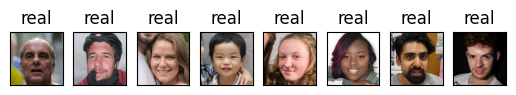

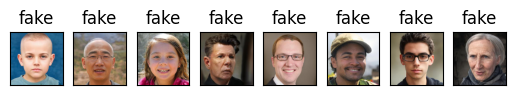

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from glob import glob

%matplotlib inline

def PrintImageSamples(image_paths, label):
    fig, ax = plt.subplots(1,len(image_paths))
    for i, path in enumerate(image_paths):
        ax[i].title.set_text(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(mpimg.imread(path))

SAMPLES = 8
real_image_paths = train_df[train_df['class'] == 'real'][:SAMPLES]['filename']
real_image_paths = [os.path.join(DATASET_TRAIN_FOLDER, p) for p in real_image_paths]
PrintImageSamples(real_image_paths, 'real')

fake_image_paths = train_df[train_df['class'] == 'fake'][:SAMPLES]['filename']
fake_image_paths = [os.path.join(DATASET_TRAIN_FOLDER, p) for p in fake_image_paths]
PrintImageSamples(fake_image_paths, 'fake')

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.io import read_image # Load image file path to ndarray

LABELS_MAP = { # Convert text labels to class index, model is trained using class indexes
    'real': 0 ,
    'fake': 1 }
NUM_CLASS = len(LABELS_MAP)

class ImageDatasetFromCSV(Dataset):
    def __init__(self, annotations_csv, root_dir, has_labels, transform=None):
        self.data_frame = pd.read_csv(annotations_csv)
        self.root_dir = root_dir
        self.has_labels = has_labels
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0]) # data_frame column 0 are filenames
        image = read_image(image_path) # In pytorch, image Tensor is in C H W dimensions
        if self.transform:
            image = self.transform(image) # Apply image augmentation transformations

        if self.has_labels: # Only training set has labels, set label=None for train=False
            label = self.data_frame.iloc[idx, 1] # Index 1 = class
            label_idx = LABELS_MAP[label] # Convert textual label to a class index
            return {"image": image, "label": label_idx}
        else:
            return {"image": image}

In [ ]:
# Train set Transforms
# Models usually take in float32 (instead of uint8 [0..255])
TRAIN_IM_W = 244
TRAIN_IM_H = 244 # 299 for inception, 384 for efficientnetv2_s, 244 for most others.
train_transform = transforms.Compose([
        transforms.Resize((TRAIN_IM_W, TRAIN_IM_H)),
        transforms.RandomHorizontalFlip(),
        transforms.ConvertImageDtype(dtype=torch.float32)])

# Test set Transforms
TEST_IM_W = 244
TEST_IM_H = 244
test_transform = transforms.Compose([
        transforms.Resize((TEST_IM_W, TEST_IM_H)),
        transforms.ConvertImageDtype(dtype=torch.float32)])

In [ ]:
# Portion out some train images for validation
TRAIN_VALID_SPLIT = [0.8, 0.2] # Ratio of train/validation split

labelled_dataset = ImageDatasetFromCSV(annotations_csv=DATASET_TRAIN_CSV, root_dir=DATASET_TRAIN_FOLDER, has_labels=True, transform=train_transform)
train_dataset, valid_dataset = random_split(labelled_dataset, TRAIN_VALID_SPLIT)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Create dataset from testing unlabelled data. Set has_labels = False since no label in csv.
test_dataset = ImageDatasetFromCSV(annotations_csv=DATASET_TEST_CSV, root_dir=DATASET_TEST_FOLDER, has_labels=False, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Dataset statistics
print(f"Total Samples - Train:{len(train_dataset)}, Val:{len(valid_dataset)}, Test:{len(test_dataset)}")

Total Samples - Train:6400, Val:1600, Test:2000


Test both train and test dataloader. See example [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterate-through-the-dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Images batch shape: torch.Size([32, 3, 244, 244])
Labels batch shape: torch.Size([32])
Label Index: 0, Label Class: real


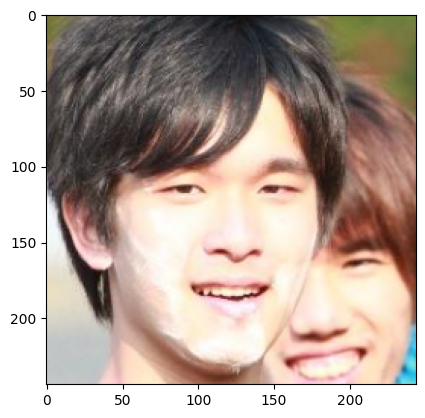

In [ ]:
# Train dataloader
extracted_batch = next(iter(train_dataloader)) # Get first batch
print(f"Images batch shape: {extracted_batch['image'].size()}")
print(f"Labels batch shape: {extracted_batch['label'].size()}")
extracted_image = extracted_batch['image'][0].squeeze() # Take 1 image to visualize
extracted_label_idx = extracted_batch['label'][0] # Take corresponding label index of image
label = list(LABELS_MAP.keys())[list(LABELS_MAP.values()).index(extracted_label_idx)] # Convert label index back to text
print(f"Label Index: {extracted_label_idx}, Label Class: {label}")

# rcParams['figure.figsize'] = 4,4 # Change display figure size
plt.imshow(np.transpose(extracted_image, (1, 2, 0))) # Convert pytorch C H W to numpy image H W C format
plt.show()

Images batch shape: torch.Size([1, 3, 244, 244])


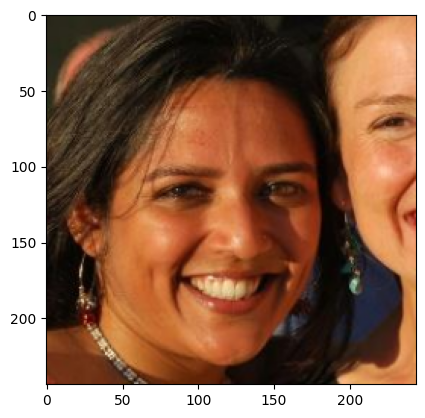

In [ ]:
# Test dataloader
extracted_test_batch = next(iter(test_dataloader))
print(f"Images batch shape: {extracted_test_batch['image'].size()}")
extracted_image = extracted_test_batch['image'][0].squeeze()
plt.imshow(np.transpose(extracted_image, (1, 2, 0)))
plt.show()

In [ ]:
from torch.nn import Linear
from torchvision.models import resnet50, ResNet50_Weights

### Change your model here, or define your custom model
def MyModel():
    pre_trained = ResNet50_Weights.DEFAULT # Choose to use pre-trained weights or not (train from scratch)
    model = resnet50(weights=pre_trained)
    model.fc = Linear(in_features=2048, out_features = NUM_CLASS) # Change out last fully connected layer to match number of classes in dataset
    return model

model = MyModel()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, Adadelta, RMSprop # Optimizers

criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(),lr=0.001, momentum=0.9) # Configure learning rate parameters as needed

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=3, min_delta=0)

In [ ]:
from tqdm import tqdm
from time import sleep


def train(model, train_dataloader, valid_dataloader, optimizer, criterion,
          num_epochs, device, save_model_path, early_stopper=None):
    model.train() # Set pytorch model to train mode
    model.to(device) # Set pytorch model to run in GPU or CPU mode

    for epoch in range(num_epochs):

        # Train
        running_train_loss = 0.0
        train_epoch = tqdm(train_dataloader) # tqdm = Progress bar
        for batch_idx, batch in enumerate(train_epoch):
            # Get batch of images & labels from Dataloader
            images = batch['image']
            labels = batch['label']
            images = images.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_train_loss += loss.item()
            train_avg_loss = running_train_loss/(batch_idx+1)
            train_epoch.set_description(f"Epoch {epoch}, Train loss: {train_avg_loss:.5f}")

        # Validation
        running_valid_loss = 0.0
        valid_epoch = tqdm(valid_dataloader)
        optimizer.zero_grad()
        for batch_idx, batch in enumerate(valid_epoch):
            images = batch['image']
            labels = batch['label']
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()
            valid_avg_loss = running_valid_loss/(batch_idx+1)
            valid_epoch.set_description(f"Epoch {epoch}, Valid loss: {valid_avg_loss:.5f}")

        print(f"Summary: Epoch {epoch} - Train loss: {train_avg_loss:.5f}, Valid loss: {valid_avg_loss:.5f}")

        # Save Model Checkpoint. See https://pytorch.org/tutorials/beginner/saving_loading_models.html#save
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_avg_loss,
            }, save_model_path)

        # Early Stopping
        if early_stopper is not None:
            if early_stopper.early_stop(valid_avg_loss):
                print(f"Early Stopping: No improvement for last {early_stopper.patience} epochs, stopping training")
                break


In [ ]:
# EPOCH = 30
# SAVE_MODEL_PATH = 'model.pt'
# train(model, train_dataloader, valid_dataloader, optimizer, criterion, EPOCH, DEVICE, SAVE_MODEL_PATH, early_stopper)

In [ ]:
# Model was trained on the previous code and Earlystopping kicked in at around the 18th epoch. Unfortunately, collab time out. Fortunately, model was saved into model.pt
model = MyModel()
checkpoint = torch.load('model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
def evaluate(model, test_dataloader, device):
    with torch.no_grad(): # https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/2
        model.eval() # Affects batch normalization and dropout layers (they work differently in training vs evaluation mode)
        model.to(device)
        predictions = []
        test_set = tqdm(test_dataloader)
        for batch_idx, batch in enumerate(test_set):
            images = batch['image']
            images = images.to(device)
            prediction = model(images)
            # If SoftmaxCrossEntopy loss was used, output is logits, convert to probability scores
            prediction = torch.nn.functional.softmax(prediction, dim=1)
            predictions.extend(prediction.tolist())
        return predictions

predictions = evaluate(model, test_dataloader, DEVICE)
print(predictions)

100%|██████████| 2000/2000 [10:03<00:00,  3.31it/s]

[[0.9972973465919495, 0.0027026513125747442], [0.04104047268629074, 0.9589595794677734], [0.9999375343322754, 6.240999209694564e-05], [0.9999786615371704, 2.1326863134163432e-05], [5.9894442529184744e-05, 0.9999401569366455], [0.8553866744041443, 0.14461329579353333], [0.00027004783623851836, 0.9997299313545227], [0.9818302989006042, 0.01816972903907299], [0.005179483909159899, 0.9948204755783081], [0.010111240670084953, 0.9898887276649475], [3.819775429292349e-06, 0.9999961853027344], [0.9999998807907104, 6.184993850411047e-08], [0.9999998807907104, 8.690190611559956e-08], [9.935734851751477e-05, 0.9999005794525146], [0.00011054074275307357, 0.9998894929885864], [0.9999998807907104, 9.372726594847336e-08], [0.00010483208461664617, 0.9998952150344849], [0.9999960660934448, 3.925184046238428e-06], [7.760672815493308e-06, 0.9999922513961792], [0.00033640151377767324, 0.9996635913848877], [0.9999710321426392, 2.8980281058466062e-05], [3.752942939172499e-05, 0.9999624490737915], [5.8317848

In [ ]:
predictions = [x[1] for x in predictions]
print(predictions)

[0.0027026513125747442, 0.9589595794677734, 6.240999209694564e-05, 2.1326863134163432e-05, 0.9999401569366455, 0.14461329579353333, 0.9997299313545227, 0.01816972903907299, 0.9948204755783081, 0.9898887276649475, 0.9999961853027344, 6.184993850411047e-08, 8.690190611559956e-08, 0.9999005794525146, 0.9998894929885864, 9.372726594847336e-08, 0.9998952150344849, 3.925184046238428e-06, 0.9999922513961792, 0.9996635913848877, 2.8980281058466062e-05, 0.9999624490737915, 0.9999417066574097, 0.9996908903121948, 4.1225399627364823e-07, 0.8251737952232361, 0.00030267026158981025, 0.0005995681276544929, 5.395478638092754e-06, 1.1981819625361823e-07, 0.9999711513519287, 0.0010419461177662015, 1.4814034329901915e-05, 0.00033599877497181296, 0.9967061877250671, 0.9999605417251587, 0.9992864727973938, 2.9305501811904833e-05, 1.429750824399889e-07, 1.5092469141109177e-07, 1.1484461538202595e-05, 4.26481028625858e-06, 2.5085589641093975e-06, 0.00010166085121454671, 0.00026239838916808367, 1.65073527114

In [ ]:
predictions = ['fake' if x>0.5 else 'real' for x in predictions]

In [ ]:
# Write to csv predictions
test_df = pd.read_csv(DATASET_TEST_CSV)
test_df['class'] = predictions
test_df.to_csv('cv_results4.csv', index=False)

# Submission

In [ ]:
cv_results = pd.read_csv("cv_results4.csv")
cv_results

,filename,class
0,./test/0.jpg,real
1,./test/1.jpg,fake
2,./test/2.jpg,real
3,./test/3.jpg,real
4,./test/4.jpg,fake
...,...,...
1995,./test/1995.jpg,real
1996,./test/1996.jpg,fake
1997,./test/1997.jpg,fake
1998,./test/1998.jpg,fake


In [ ]:
submission = pd.read_csv("test.csv")
submission['nlp_class'] = preds
submission['cv_class'] = cv_results["class"]
submission = submission[["nlp_title", "nlp_text", "nlp_comments", "nlp_class", "cv_filename", "cv_class"]]
submission.to_csv("tway_9.csv", index=False)